In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from datetime import date,datetime
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# Wholesale Customer Loyalty Analysis

You work at a small food service supply wholesaler that principally services the hotel/restaurant and retail channels.

My CEO would like to understand whether the loyalty program which encourages to purchase across multiple offering categories will boost sale.

My CEO would like you to analyze annual spending by the company’s current customers to understand if such a program would be attractive to the largest subgroup of customers. 


## Data Wrangling

In [4]:
df = pd.read_csv('wholesale_data.csv')
print('Number of rows:',len(df))
df.head()

Number of rows: 801


,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,6048141,2017,12669,9656,7561,214,2674,1338
1,2,9336325,2017,7057,9810,9568,1762,3293,1776
2,2,6272942,2017,6353,8808,7684,2405,3516,7844
3,1,7856217,2017,13265,1196,4221,6404,507,1788
4,2,6179511,2017,22615,5410,7198,3915,1777,5185


In [5]:
df.dtypes

Channel              int64
Customer             int64
Year                object
Fresh               object
Milk                object
Grocery             object
Frozen              object
Detergents_Paper    object
Delicassen          object
dtype: object

In [6]:
df['Channel'].value_counts()

1    525
2    276
Name: Channel, dtype: int64

In [7]:
df['Year'].value_counts()

2017          440
08/01/2016    361
Name: Year, dtype: int64

In [8]:
# print('Fresh\n', df['Fresh'].value_counts())
# print('Milk\n'
#       ,df['Milk'].value_counts())
# print('Grocery\n',
#       df['Grocery'].value_counts())
# print('Frozen\n',
#       df['Frozen'].value_counts())
# print('Detergents_Paper\n',
#       df['Detergents_Paper'].value_counts())
# print('Delicassen\n',
#       df['Delicassen'].value_counts())

Almost half of the wholesale 'year' column is '08/01/2016'. 
We replace each of these by 2016 and cast the 2017's as int's.

In [9]:
df['Year'] = df['Year'].apply(lambda y: 2016 if y == '08/01/2016' else int(y))

In [10]:
df['Clean_Year'] = pd.to_datetime(df['Year'], format='%Y')

In [11]:
print(len(df.Customer))
print(len(df.Customer.unique()))
print(len(df[df['Year'] == 2016].Customer))
print(len(df[df['Year'] == 2016].Customer.unique()))
print(len(df[df['Year'] == 2017].Customer))
print(len(df[df['Year'] == 2017].Customer.unique()))
df['is_duplicated'] = df.duplicated(['Customer'])
print(df['is_duplicated'].sum())

801
479
361
361
440
440
322


322 (duplicates) customers appearing both in 2016 and 2017 .

In [12]:
df.drop('is_duplicated', axis=1, inplace=True)

In [13]:
product_columns =['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']

In [14]:
# convert to numeric, all strings become nans
for col in product_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dtypes

Channel                      int64
Customer                     int64
Year                         int64
Fresh                      float64
Milk                       float64
Grocery                    float64
Frozen                     float64
Detergents_Paper           float64
Delicassen                 float64
Clean_Year          datetime64[ns]
dtype: object

We infer these categories.

In [15]:
df['Cleaned_Channel'] = 'HoReCa'
df['Cleaned_Channel'][df.Channel == 2] = 'Retail'
df.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Clean_Year,Cleaned_Channel
0,2,6048141,2017,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,2017-01-01,Retail
1,2,9336325,2017,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,2017-01-01,Retail
2,2,6272942,2017,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0,2017-01-01,Retail
3,1,7856217,2017,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,2017-01-01,HoReCa
4,2,6179511,2017,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0,2017-01-01,Retail


In [16]:
# for col in product_columns:
#     print(col)
#     true_strings = pd.to_numeric(df[col],
#                                 errors='coerce').isnull()
#     print('Number of true strings: {}'.format(df.loc[true_strings, col].count()))
#     print('List of true strings: {}'.format(df.loc[true_strings, col].unique()))
#     print(df.loc[true_strings, col])
#     print('-'*50)

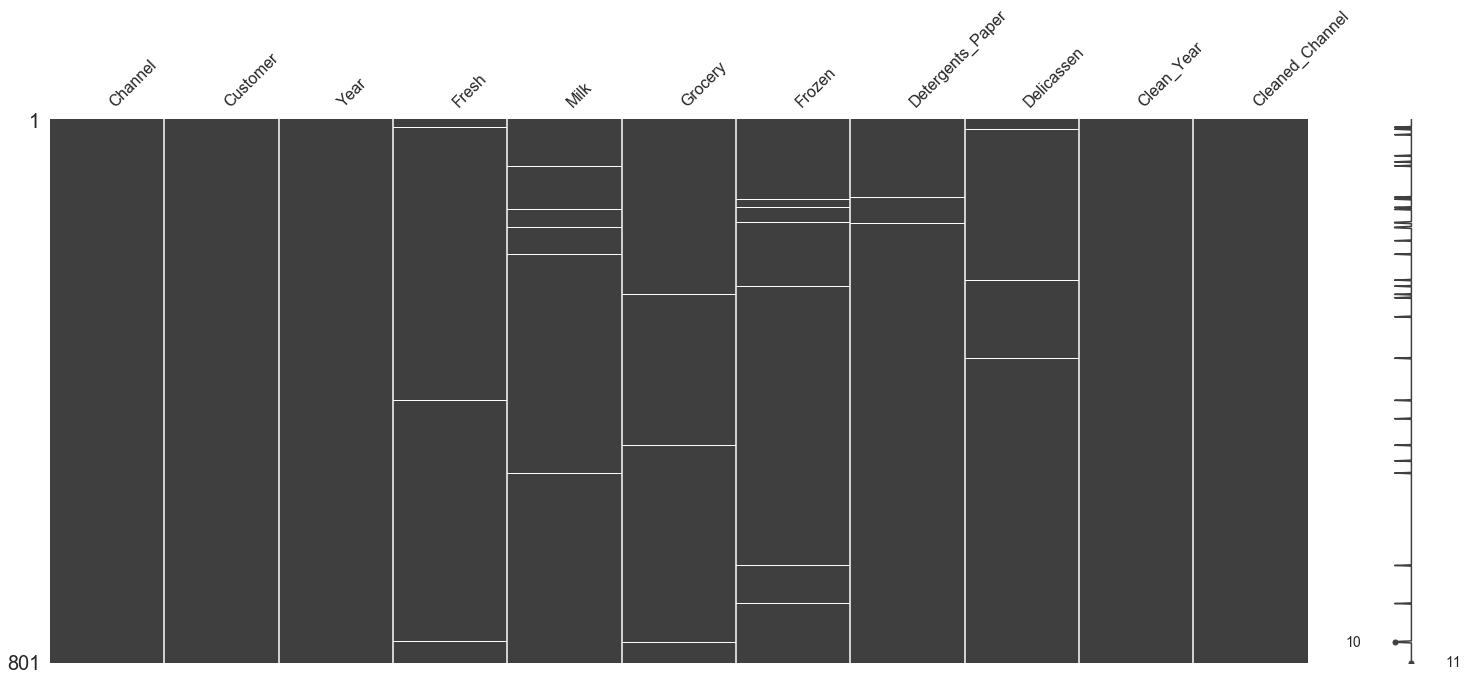

In [17]:
msno.matrix(df);

Only few missing values, so we can drop the nan values.

In [18]:
n_orig = len(df)
df.dropna(inplace=True)
print(r'dropped {} % of rows'.format((1 - len(df)/n_orig)*100))

dropped 3.8701622971285876 % of rows


In [19]:
customer_pool = df.groupby(['Customer']).mean()
customer_pool.reset_index(inplace=True)
customer_pool.head()

,Customer,Channel,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1133724,2.0,2016.0,16879.0,27681.0,16734.0,3402.0,3600.0,11566.0
1,1134744,1.0,2016.5,13230.0,309.5,408.5,1713.5,36.0,629.5
2,1140622,1.0,2017.0,2121.0,1601.0,2453.0,560.0,179.0,712.0
3,1143896,1.0,2016.0,15327.0,2073.0,362.0,2641.0,22.0,863.0
4,1176235,1.0,2016.5,41304.0,5775.0,5294.0,7294.5,1310.0,188.5


In [20]:
cleaned_df_long = pd.melt(df, id_vars=['Year','Cleaned_Channel'],
                            value_vars=product_columns,
                            var_name = 'Product', value_name = 'Spending')
cleaned_df_long.head()

,Year,Cleaned_Channel,Product,Spending
0,2017,Retail,Fresh,12669.0
1,2017,Retail,Fresh,7057.0
2,2017,Retail,Fresh,6353.0
3,2017,HoReCa,Fresh,13265.0
4,2017,Retail,Fresh,22615.0


# EDA

## Spending per product

In [21]:
product_grouped = cleaned_df_long[['Product','Spending']].groupby(['Product']).sum()
product_grouped.reset_index(inplace=True)
product_grouped.head()

,Product,Spending
0,Delicassen,1041429.0
1,Detergents_Paper,2104760.0
2,Fresh,8489426.0
3,Frozen,2061715.0
4,Grocery,5589055.0


In [22]:
spending_order = product_grouped.sort_values(by='Spending', ascending=False)['Product'].values
spending_order[:10]

array(['Fresh', 'Grocery', 'Milk', 'Detergents_Paper', 'Frozen',
       'Delicassen'], dtype=object)

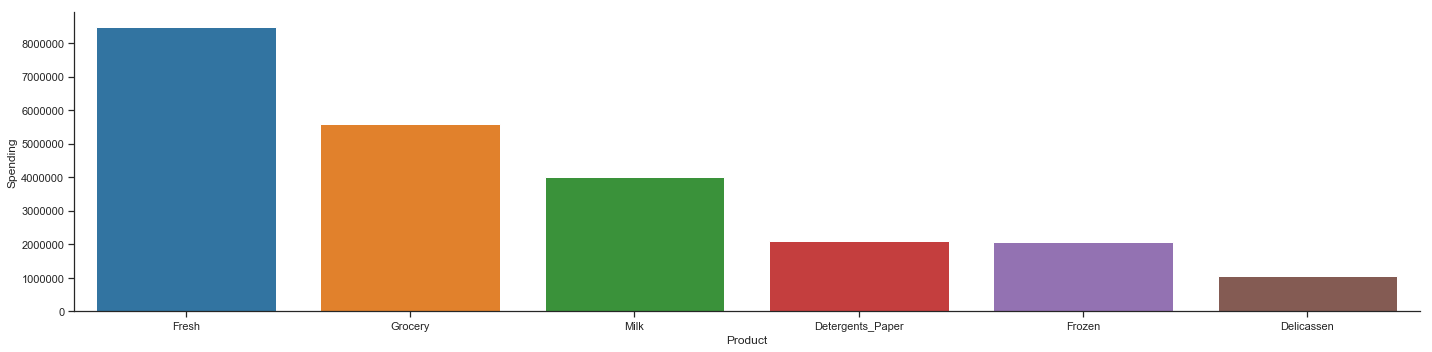

In [23]:
plt.figure(figsize=(20,5))
sns.barplot(data=product_grouped, x='Product',y='Spending', order=spending_order[:10]);
sns.despine()
plt.tight_layout()

## Focus on Customers

In [24]:
df['Total_Spending'] = df.loc[:, product_columns].sum(axis=1)
df_2016 = df[df['Year'] == 2016]
df_2017 = df[df['Year'] == 2017]

In [25]:
total_spending_2016 = df_2016['Total_Spending'].sum(axis=0)
print(r'Total spending in 2016:', total_spending_2016)
total_spending_2017 = df_2017['Total_Spending'].sum(axis=0)
print(r'Total spending in 2017:', total_spending_2017)
print(r'Spending increase of:{}%'.format(str(round((total_spending_2017 - total_spending_2016)/total_spending_2016 * 100.0, 2))))

Total spending in 2016: 9358222.0
Total spending in 2017: 13942037.0
Spending increase of:48.98%


In [26]:
two_times_customers_idx = df['Customer'].value_counts()[df['Customer'].value_counts() == 2].index
two_time_customers = df[df['Customer'].isin(two_times_customers_idx)]
two_time_customers.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Clean_Year,Cleaned_Channel,Total_Spending
0,2,6048141,2017,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,2017-01-01,Retail,34112.0
2,2,6272942,2017,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0,2017-01-01,Retail,36610.0
3,1,7856217,2017,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,2017-01-01,HoReCa,27381.0
4,2,6179511,2017,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0,2017-01-01,Retail,46100.0
5,2,2288780,2017,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,2017-01-01,Retail,26710.0


In [27]:
two_times_customers_sorted = two_time_customers.sort_values(by=['Customer','Year'])
two_times_customers_sorted['total'] = two_times_customers_sorted.apply(lambda row: sum(row[col] for col in product_columns), axis=1)
two_times_customers_sorted.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Clean_Year,Cleaned_Channel,Total_Spending,total
687,1,1134744,2016,12891.0,273.0,328.0,1350.0,28.0,600.0,2016-01-01,HoReCa,15470.0,15470.0
247,1,1134744,2017,13569.0,346.0,489.0,2077.0,44.0,659.0,2017-01-01,HoReCa,17184.0,17184.0
616,1,1176235,2016,36968.0,4592.0,4052.0,7221.0,1088.0,147.0,2016-01-01,HoReCa,54068.0,54068.0
176,1,1176235,2017,45640.0,6958.0,6536.0,7368.0,1532.0,230.0,2017-01-01,HoReCa,68264.0,68264.0
469,1,1182105,2016,42226.0,1092.0,1670.0,720.0,720.0,502.0,2016-01-01,HoReCa,46930.0,46930.0


In [28]:
year_over_year_total = [two_times_customers_sorted.iloc[2*idx + 1,-1]/two_times_customers_sorted.iloc[2*idx,-1] 
                        for idx in range(int(two_times_customers_sorted.shape[0]/2))]
customer_expenses_2016_2017 = pd.Series(year_over_year_total);

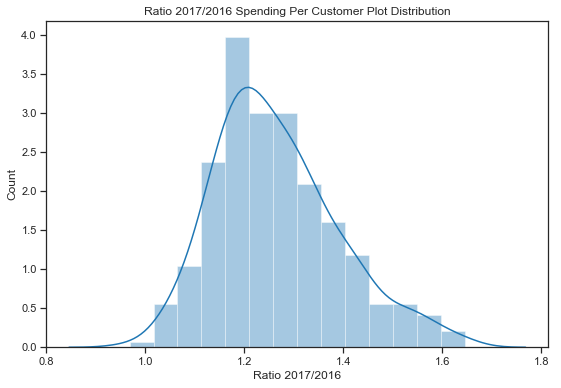

In [29]:
fig, ax = plt.subplots()
sns.distplot(pd.Series(year_over_year_total), kde=True, ax=ax)
ax.set_xlabel('Ratio 2017/2016')
ax.set_ylabel('Count')
ax.set_title('Ratio 2017/2016 Spending Per Customer Plot Distribution');

On average customers spent between 1.1 and 1.3 times more in 2017 vs. 2016.

## Spending per Channel

In [30]:
channel_df = cleaned_df_long[['Cleaned_Channel', 'Spending']]
channel_df.head()

,Cleaned_Channel,Spending
0,Retail,12669.0
1,Retail,7057.0
2,Retail,6353.0
3,HoReCa,13265.0
4,Retail,22615.0


In [31]:
channel_grouped = channel_df.groupby(['Cleaned_Channel']).sum()
channel_grouped.reset_index(inplace=True)
channel_grouped.head()

,Cleaned_Channel,Spending
0,HoReCa,12582321.0
1,Retail,10717938.0


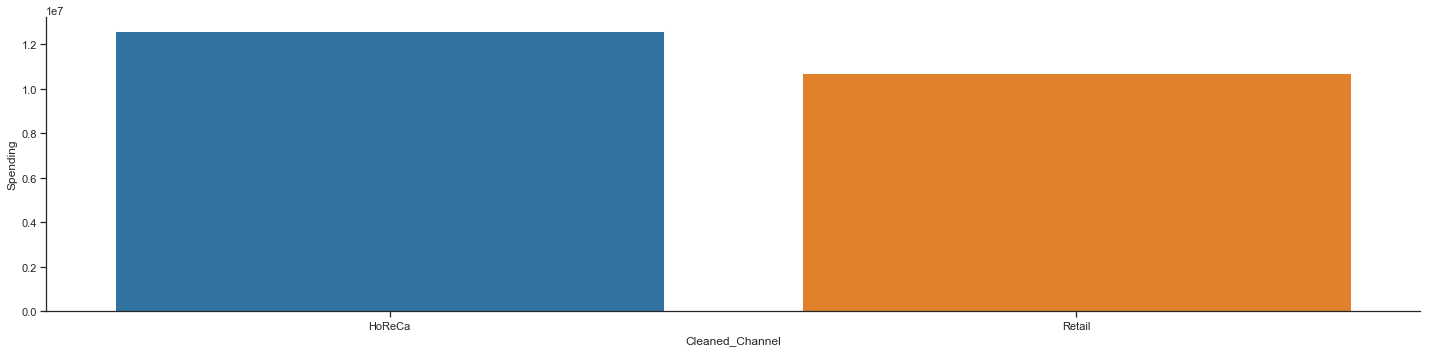

In [32]:
plt.figure(figsize=(20,5))
sns.barplot(data=channel_grouped, x='Cleaned_Channel',y='Spending');
sns.despine()
plt.tight_layout()

### Plot total amounts for each Channel per product category

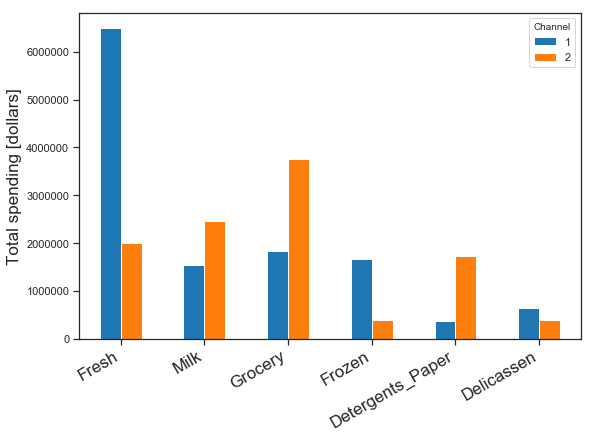

In [33]:
yield_per_category = df[product_columns + ['Channel']].groupby(['Channel']).sum().transpose()
yield_per_category.plot.bar()
_ = plt.ylabel(r'Total spending [dollars]', fontsize=17)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, rotation = 30, ha='right')
#plt.savefig(r'total_spending_per_channel.pdf', bbox_inches='tight', transparent=True)

## Plot mean amounts for each Channel per product category

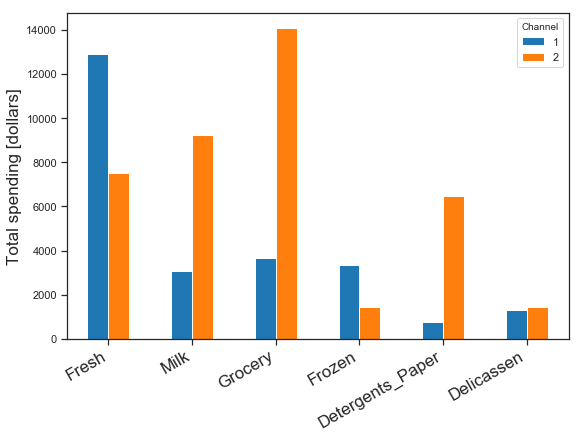

In [34]:
yield_per_category = df[product_columns + ['Channel']].groupby(['Channel']).mean().transpose()
yield_per_category.plot.bar()
_ = plt.ylabel(r'Total spending [dollars]', fontsize=17)
ax = plt.gca()
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=17, rotation = 30, ha='right')

#### Based on the above, we can conclude that Channel 1 stands for HoReCa and Channel 2 for Retail
* Spending order for HoReCa: Fresh, Grocery, Frozen, Milk, Delicassen
* Spending order for Retail: Grocery, Milk, Fresh, Detergent_Paper

### Focus on 2017

In [35]:
df_2017.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Clean_Year,Cleaned_Channel,Total_Spending
0,2,6048141,2017,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,2017-01-01,Retail,34112.0
1,2,9336325,2017,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,2017-01-01,Retail,33266.0
2,2,6272942,2017,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0,2017-01-01,Retail,36610.0
3,1,7856217,2017,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,2017-01-01,HoReCa,27381.0
4,2,6179511,2017,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0,2017-01-01,Retail,46100.0


In [36]:
df_2017_Ch1 = df_2017[df_2017.Channel == 1]
df_2017_Ch2 = df_2017[df_2017.Channel == 2]

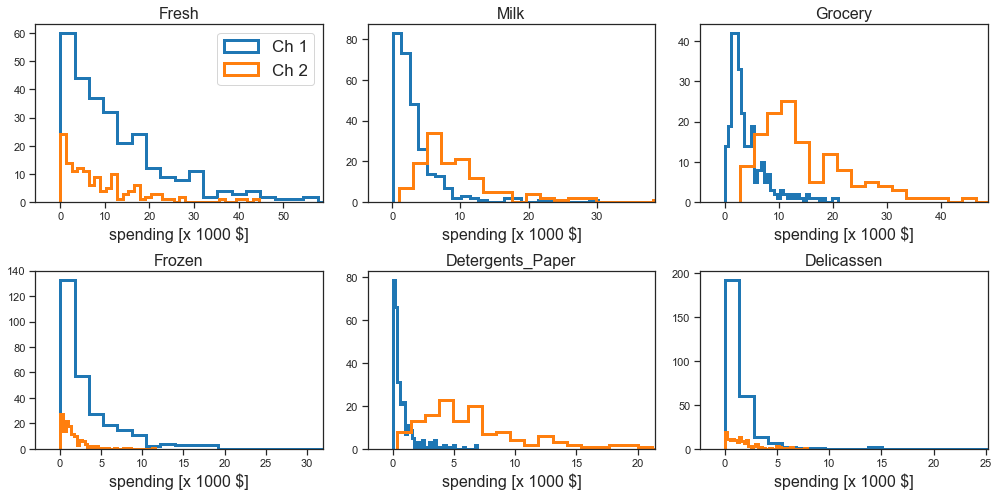

In [37]:
fig, axes = plt.subplots(2,3, figsize = (14,7))
count = 0
for axrow in axes:
    for ax in axrow:
        ax.hist(df_2017_Ch1[product_columns[count]]/1000, bins = 35, histtype='step', linewidth=3, label = r'Ch 1')
        ax.hist(df_2017_Ch2[product_columns[count]]/1000, bins = 35, histtype='step', linewidth=3, label = r'Ch 2')
        ax.set_title(product_columns[count], fontsize=16)
        ax.set_xlabel(r'spending [x 1000 $]', fontsize=16)
        ax.set_xlim(ax.get_xlim()[0], 0.5 * ax.get_xlim()[1])
        if count == 0:
            ax.legend(loc='upper right', fontsize=17)
        count += 1
plt.tight_layout()
#plt.savefig(r'spending_histograms.pdf', bbox_inches='tight', transparent=True)

* For HoReCa (Channel 1): main products are Fresh, Frozen, Milk and Grocery
* For Retail (Channel 2): main products are Grocery, Milk, Fresh, Detergents_Paper

###  HoReCa (Channel 1) Correlation Coefficients Analysis

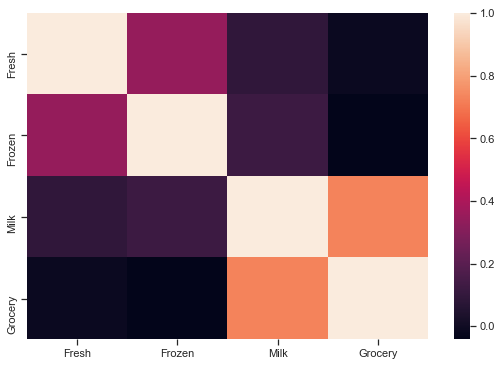

In [38]:
spending_categories_Ch1 = ['Fresh', 'Frozen', 'Milk', 'Grocery']
cormat = df_2017[spending_categories_Ch1].corr()
sns.heatmap(cormat, xticklabels=cormat.columns.values,yticklabels=cormat.columns.values)
#plt.savefig('cormat_Ch1.pdf', bbox_inches='tight')

In [39]:
cormat

,Fresh,Frozen,Milk,Grocery
Fresh,1.000000,0.348780,0.092126,-0.012465
Frozen,0.348780,1.000000,0.124486,-0.041074
Milk,0.092126,0.124486,1.000000,0.730180
Grocery,-0.012465,-0.041074,0.730180,1.000000


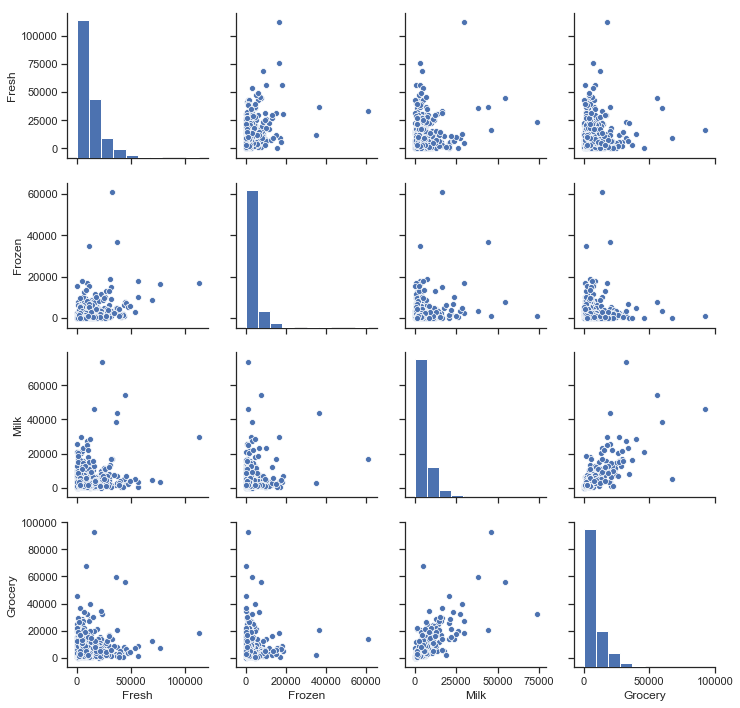

In [40]:
sns.set(style="ticks")
sns.pairplot(df_2017[spending_categories_Ch1]);

There seems to be large variations in the features, we will log-transform the values.

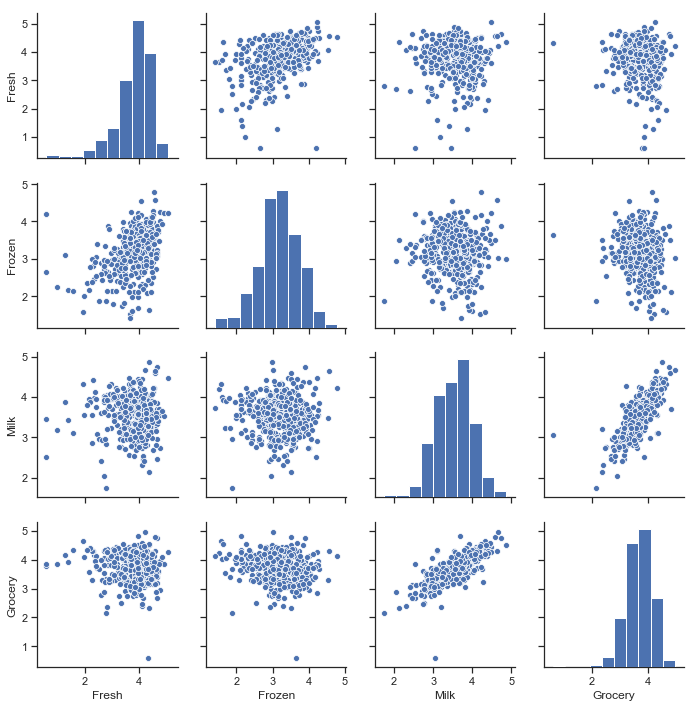

In [41]:
df_2017[spending_categories_Ch1] = df_2017[spending_categories_Ch1].apply(lambda x:np.log10(x+1))
sns.set(style="ticks")
sns.pairplot(df_2017[spending_categories_Ch1])

Positive correlation between Milk and Grocery and somehow between Fresh and Frozen.

In [42]:
df_2017_Ch1 = df_2017[spending_categories_Ch1] 

In [43]:
pd.crosstab(df_2017_Ch1.Milk > df_2017_Ch1.Milk.median(), df_2017_Ch1.Grocery > df_2017_Ch1.Grocery.median())

Grocery,False,True
Milk,,
False,173,36
True,36,172


In [44]:
pd.crosstab(df_2017_Ch1.Fresh > df_2017_Ch1.Fresh.median(), df_2017_Ch1.Frozen > df_2017_Ch1.Frozen.median())

Frozen,False,True
Fresh,,
False,130,79
True,79,129


In [45]:
173/209, 130/209

(0.8277511961722488, 0.6220095693779905)

*So among the customers who spent more than the median on Milk, 82% will spend more than the median on Grocery and for the ones spending more than the median on Fresh, 62% will spend more than the median on Frozen.*

# Conclusion for  HoReCa (Channel 1): 
    * Main products are Fresh, Frozen, Milk and Grocery.
    * Milk and Grocery are commonly bought together, as are Fresh and Frozen.
    * These customers will benefit from a loyalty program which encourages to purchase across multiple offering categories.

###  Retail (Channel 2) Correlation Coefficients Analysis

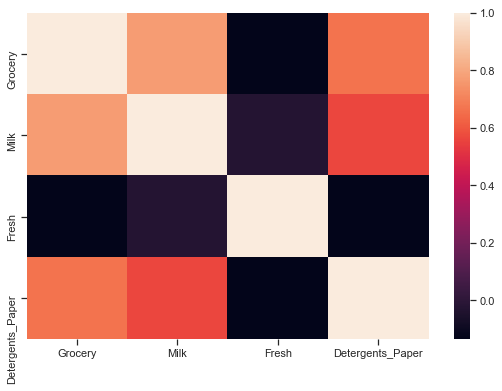

In [46]:
spending_categories_Ch2 = ['Grocery', 'Milk', 'Fresh', 'Detergents_Paper']
df_2017_Ch2 = df_2017[spending_categories_Ch2] 
cormat = df_2017_Ch2.corr()
sns.heatmap(cormat, xticklabels=cormat.columns.values,yticklabels=cormat.columns.values);

In [47]:
cormat

,Grocery,Milk,Fresh,Detergents_Paper
Grocery,1.000000,0.770508,-0.129712,0.666192
Milk,0.770508,1.000000,-0.025092,0.565291
Fresh,-0.129712,-0.025092,1.000000,-0.133773
Detergents_Paper,0.666192,0.565291,-0.133773,1.000000


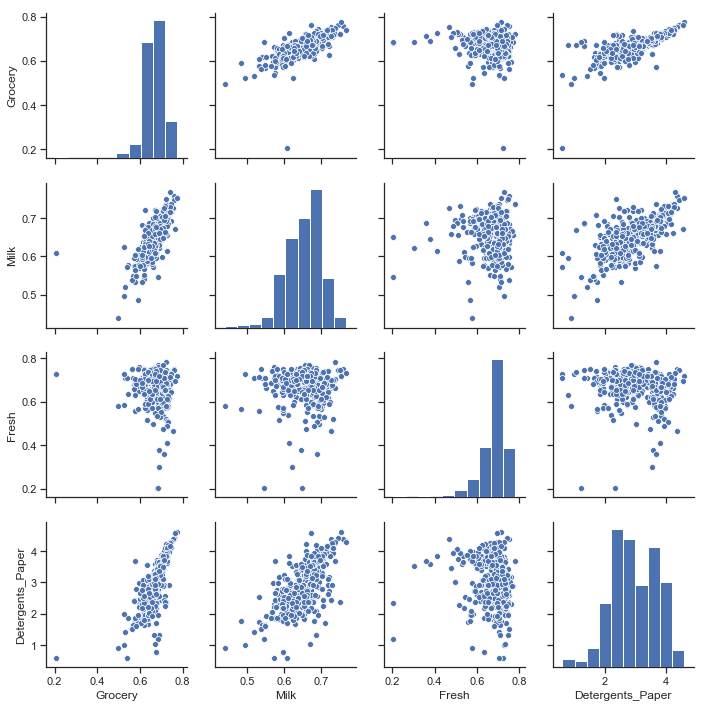

In [48]:
df_2017_Ch2 = df_2017_Ch2.apply(lambda x:np.log10(x+1))
sns.set(style="ticks")
sns.pairplot(df_2017_Ch2);

Positive correlation between Milk and Grocery, Milk and Detergent_Papers, Grocery and Detergents_Paper.

In [49]:
pd.crosstab(df_2017_Ch2.Milk > df_2017_Ch2.Milk.median(), df_2017_Ch2.Grocery > df_2017_Ch2.Grocery.median())

Grocery,False,True
Milk,,
False,173,36
True,36,172


In [50]:
pd.crosstab(df_2017_Ch2.Milk > df_2017_Ch2.Milk.median(), df_2017_Ch2.Detergents_Paper > df_2017_Ch2.Detergents_Paper.median())

Detergents_Paper,False,True
Milk,,
False,165,44
True,44,164


In [51]:
pd.crosstab(df_2017_Ch2.Grocery > df_2017_Ch2.Grocery.median(), df_2017_Ch2.Detergents_Paper > df_2017_Ch2.Detergents_Paper.median())

Detergents_Paper,False,True
Grocery,,
False,172,37
True,37,171


In [52]:
173/209,165/209,172/209

(0.8277511961722488, 0.7894736842105263, 0.8229665071770335)

*So among the customers who spent more than the median on Milk, 82% will spend more than the median on Grocery and for the ones spending more than the median on Milk, 78% will spend more than the median on Detergents_paper, and lastly for the people spending more than the median on Grocery, 82% are likely to spend more on Detergents_Paper.*

# Conclusion for  Retail (Channel 2): 
    * Main products are Grocery, Milk, Fresh, Detergents_Paper.
    * Milk and Grocery are commonly bought together, as are Milk and Detergents_paper, and Grocery and Detergents_paper.
    * These customers will benefit from a loyalty program which encourages to purchase across multiple offering categories.

# Overall conclusion: for both channels HoReCa and Retail, loyalty program is likely to boost sales.